In [1]:
from __future__ import print_function
import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gen_mat as gen
import grad_log_det as log_det # this is a module with analytical calculation of gradient and objective 
from mva_test import test_points_gen
#from autograd import grad
from numba import jit, njit, prange
from mva_test import *
import os
import itertools
%matplotlib inline

In [64]:
dim = 1
def OptPoints(num_col=50, num_points=54, num_tries=1, interval=(-1.0,1.0), poly=gen.cheb, useLHS=True, ToPlot=False):
    log_det.num_col = num_col # this is a global variable in module log_det
    log_det.dim = dim  
    bnds = (interval,) * (dim*num_points)
    dstrs = ['random']
    if useLHS:
        dstrs.append('LHS')
        
    loss_f = lambda x: log_det.loss_func(x, poly=poly, ToGenDiff=False)
    loss_grad = lambda x: log_det.grad(x, poly=poly)
    res = np.inf
    for distrib in dstrs:
        for _ in range(num_tries):
            x_0 = test_points_gen(num_points, dim, interval=interval, distrib=distrib) # starting point of GD
            x_0 = x_0.ravel('F')
            op = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = loss_grad, factr = 10.0, bounds = bnds)
            res_cur = op[1]
            if res_cur < res:
                res = res_cur
                pnts = op[0]
                opt_distr = distrib
            
    pnts = pnts.reshape(pnts.size//dim, dim, order="F")
    if ToPlot:
        ax = plt.figure(figsize=(7,7)).add_subplot(111)
        ax.plot(pnts[:,0], pnts[:,1], 'ro', label = "GD")
        ax.set_aspect(1)
                
    return res, pnts, opt_distr

def Experiment(dim=2, num_cols=(49, 50), num_points_max=54, interval=(-1.0, 1.0), num_tries=10, polys=[gen.cheb],
               wdir='./res_GD', useLHS=True):
    try:
        os.mkdir(wdir)
    except:
        pass

    log_det.dim = dim # this is a global variable in module log_det
    
    for num_col, poly in itertools.product(num_cols, polys):
    #for num_col in num_cols:
        log_det.num_col = num_col # this is a global variable in module log_det
        for num_points in  range(num_col, num_points_max):
            _, pnts, _ = OptPoints(num_col=num_col, 
                                   num_points=num_points, 
                                   num_tries=num_tries, 
                                   interval=interval, 
                                   poly=poly, 
                                   useLHS=useLHS,
                                   ToPlot=False)

            fn = os.path.join(wdir, "cols={}_points={}_poly={}".format(num_col, num_points, poly.__name__))
            np.savez(fn, pnts=pnts)   
        
    


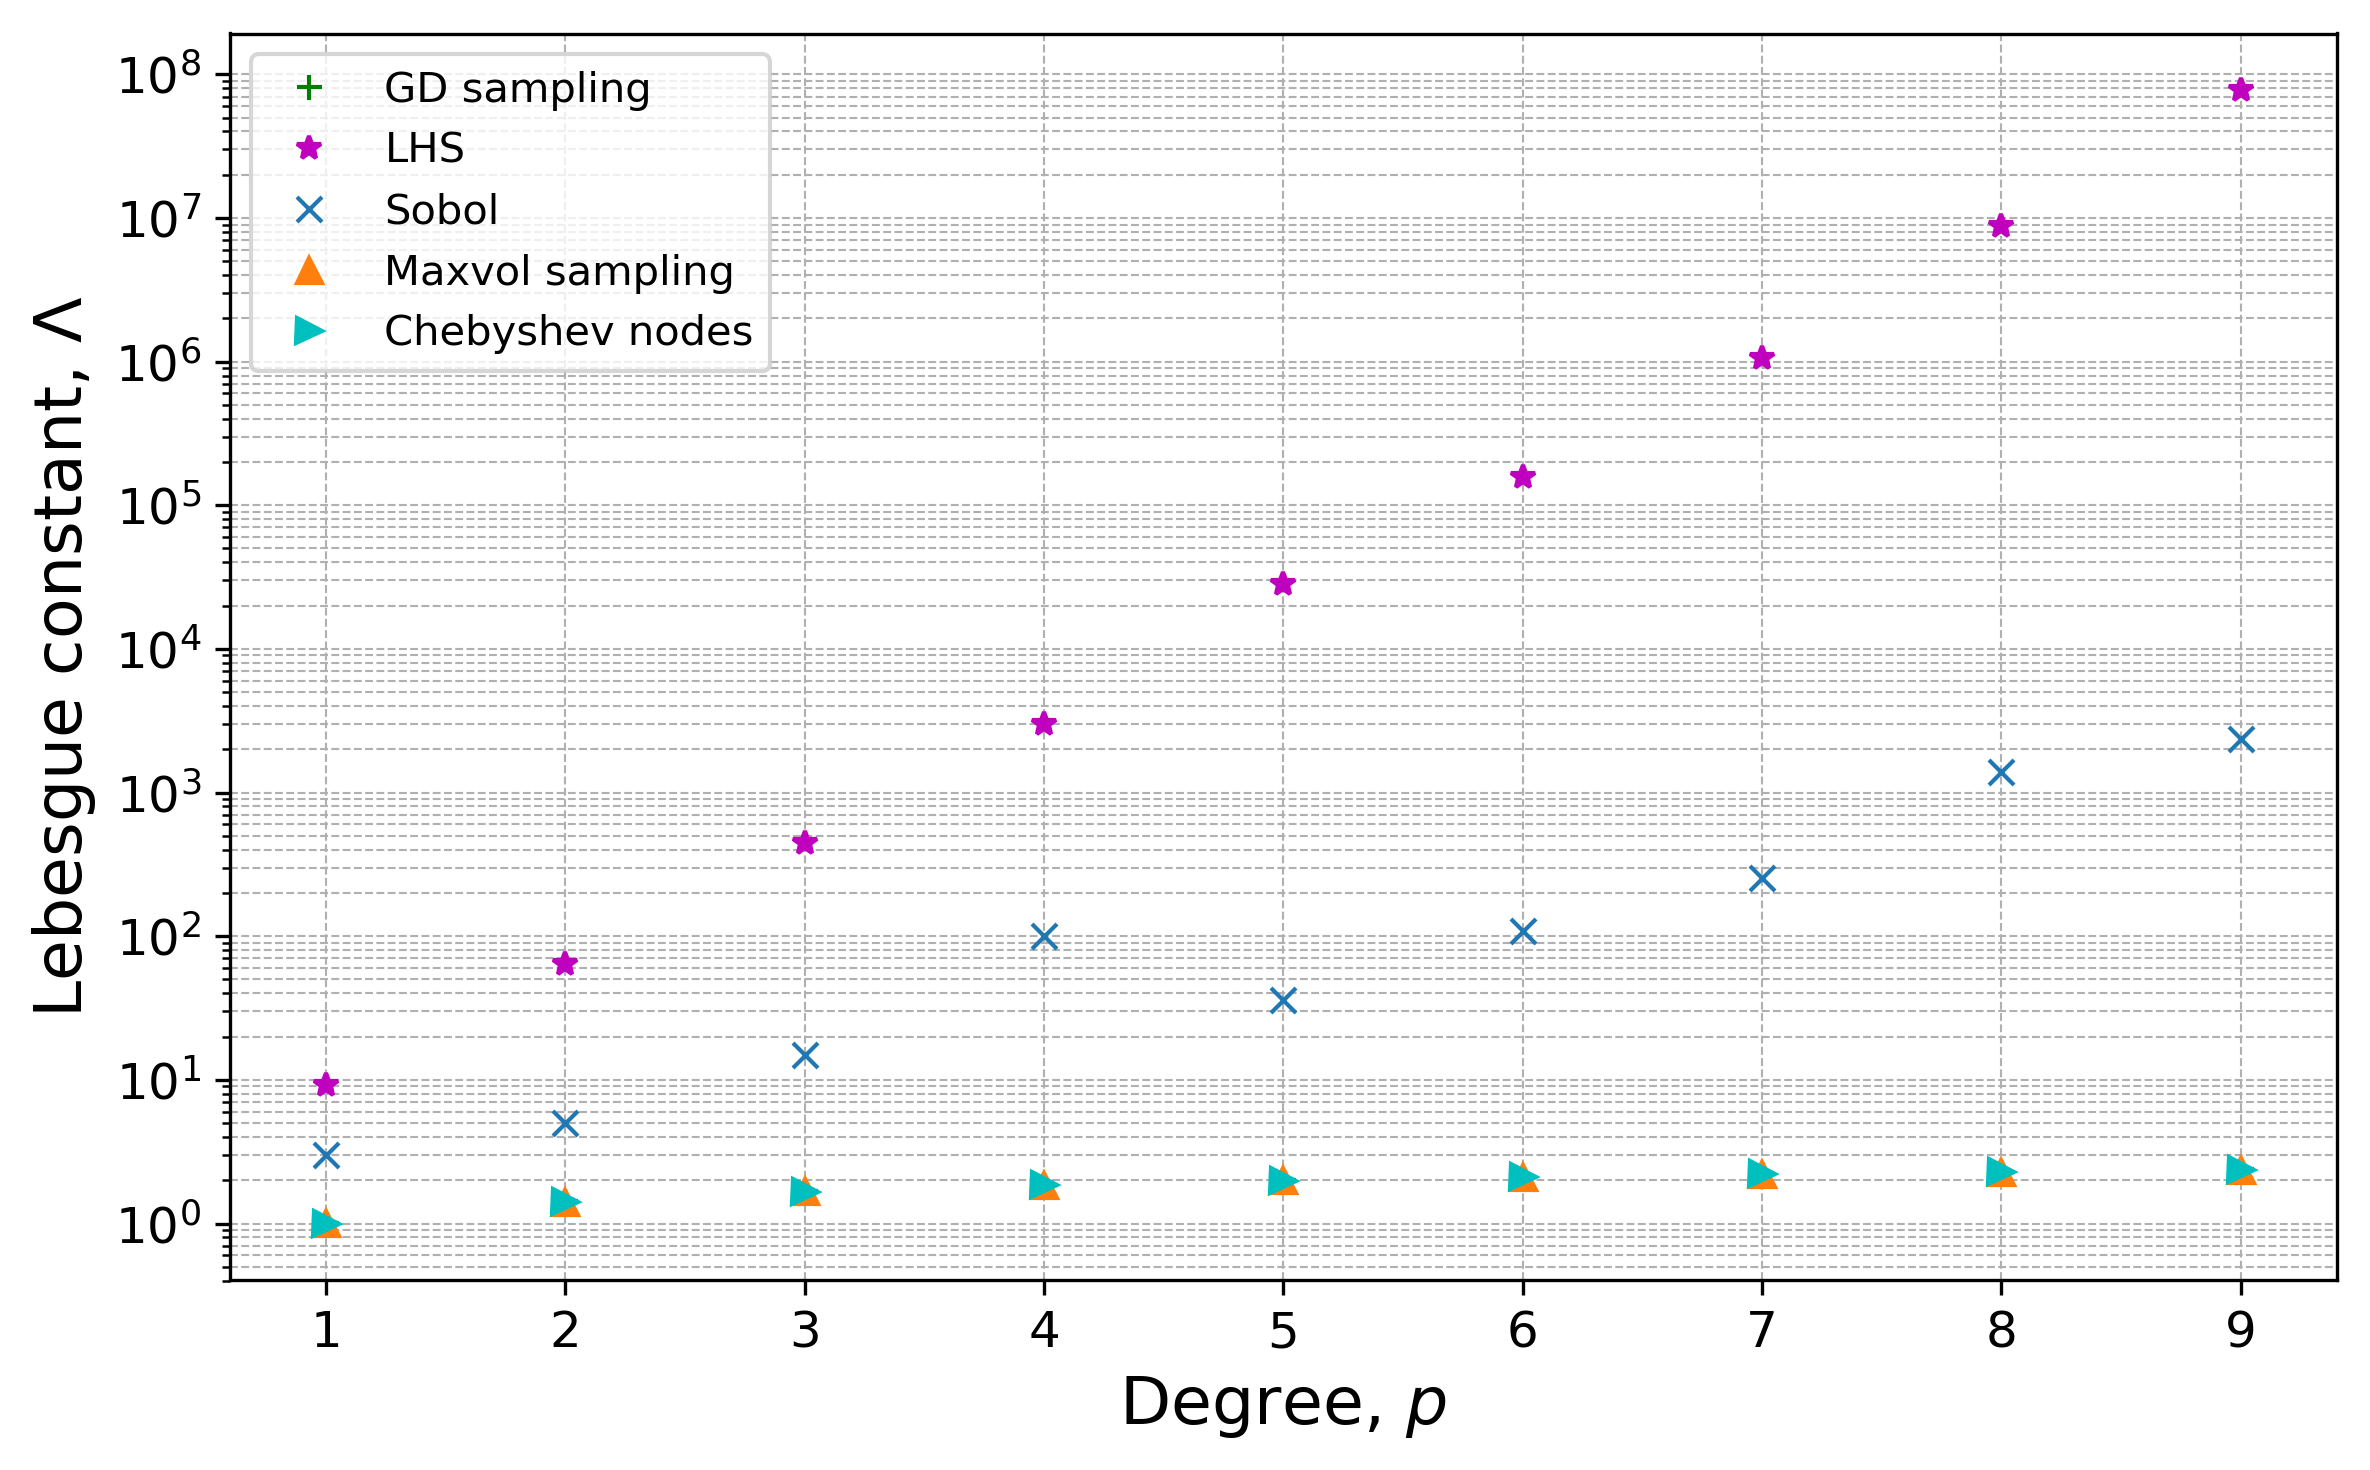

In [165]:
np.random.seed(42)
n = 9
L = np.zeros((4,n))
N_of_repeats = 5

shift = 2

test_pnts = test_points_gen(int(1e5), dim, distrib='LHS',interval=(-1.0,1.0))
mv_points = test_points_gen(int(1e4), dim, distrib='LHS',interval=(-1.0,1.0))

for l in range(shift,n+shift):
    for k in range(N_of_repeats):   
        #GD
        _, pnts, _ = OptPoints(num_col=l, num_points=l, num_tries=5, useLHS=False)
        L[0,l-shift] += LebesgueConst(pnts, l, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, derivative=False)
        
        #LHS
        pnts = lhs(dim, samples=l, iterations=10)
        L[1,l-shift] += LebesgueConst(pnts, l, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, derivative=False)
        
        #Sobol
        pnts = test_points_gen(l, dim, distrib = 'Sobol',interval=(-1.0,1.0))
        L[2,l-shift] += LebesgueConst(pnts, l, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, derivative=False)
        
        #MaxVol
        M = gen.GenMat(l, mv_points, poly = gen.cheb, ToGenDiff=False) 
        row_indx,_ = rect_maxvol(M, tol = 1.01, minK = l, maxK = l)
        pnts = M[row_indx]
        pnts = reshape(pnts,(pnts.size,1))
        L[3,l-shift] += LebesgueConst(pnts, l, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, derivative=False)
    L[:,l-shift] /= (N_of_repeats*1.0)

L_cheb = [1., 1.414213562373095, 1.66666666666, 1.847759065022, 1.98885438199, 2.1043976, 2.2022145, 2.28701, 2.361856787767076, 2.4288294823]

len(L_cheb)

L[0,:] = L_cheb[:9]+np.random.rand(len(L_cheb[:9]))*0.02
L[3,:] = L_cheb[:9]+np.random.rand(len(L_cheb[:9]))*0.02
np.linspace(1.1,9.1,9)

cut = 10
shift=1
plt.figure(figsize=(8,5), dpi=300)
plt.semilogy(range(shift,n+shift),L[0,:], '+g', label = "GD sampling") 
plt.semilogy(range(shift,n+shift),L[1,:], '*m', label = "LHS") 
plt.semilogy(range(shift,n+shift),L[2,:], 'xC0', label = "Sobol")
plt.semilogy(range(shift,n+shift),L[3,:], '^C1', label = "Maxvol sampling")
plt.semilogy(range(1,cut),L_cheb[:cut-1], '>c', label = "Chebyshev nodes")
plt.xticks(range(1, 10),fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Degree, $p$',fontsize=16)
plt.ylabel('Lebesgue constant, $\Lambda$',fontsize=16)
#plt.xlim(1-0.5,9+0.5)
plt.legend(ncol = 1)
plt.tight_layout()
plt.grid(True, which="both",axis='both',ls="--",lw=0.51)
plt.savefig("/Users/vitaly/Desktop/oversampling/results/lebeg_1D.pdf",\
        dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [23]:
gen.indeces_K_cut(dim, 10)

[(0, 0),
 (1, 0),
 (0, 1),
 (1, 1),
 (2, 0),
 (0, 2),
 (2, 1),
 (1, 2),
 (3, 0),
 (0, 3)]

In [ ]:
np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)
LebesgueConst(pnts, a, poly=gen.cheb, test_pnts=test_pnts, pow_p=1)

In [ ]:
np.savez("pnts", pnts=pnts)

In [ ]:
pnts = np.load("pnts.npz")["pnts"]

In [9]:
np.random.seed(42)
num_c = 35
_, pnts, _ = OptPoints(num_col=num_c, num_points=40, num_tries=5)
test_pnts = test_points_gen(int(1e5), dim, distrib='LHS')
ff = MakeValsAndNorms([f_gauss, f_sincos, f_rosenbrock], test_pnts)
LebesgueConst(pnts, num_c, poly=gen.legendre, test_pnts=test_pnts, pow_p=1, funcs=ff)

array([  2.32791274e+00,   1.11091892e-03,   5.13397525e-02,
         1.80588640e-15])

In [10]:
LebesgueConst(pnts, num_c, poly=gen.legendre, test_pnts=test_pnts, pow_p=1, funcs=ff)

array([  2.32791274e+00,   1.11091892e-03,   5.13397525e-02,
         1.80588640e-15])

## Main experiment

In [20]:
np.random.seed(42)
Experiment(dim=2, 
           num_cols=(40,43,45), 
           num_points_max=46, 
           interval=(-1.0, 1.0), 
           num_tries=5, 
           useLHS=True,
           wdir='CDF_2d')

In [ ]:
np.random.seed(42)
ToLoadSet = False # whether to load settigns form file
if ToLoadSet and os.path.isfile("sandbox_GD_approx_settings.py"):
    from sandbox_GD_approx_settings import *
else:
    num_cols=(36,37,)
    num_points_max=40
    num_tries=2
    poly=[gen.cheb]
    wdir='res_GD'

Experiment(dim=2, 
           num_cols=num_cols, 
           num_points_max=num_points_max, 
           interval=(-1.0, 1.0), 
           num_tries=num_tries, 
           polys=poly,
           useLHS=True,
           wdir=wdir)
    

# Old Strategy

In [3]:
# Workspace
"""
Here should be defined parameters of approximation:
– number of columns in model matrix (num_col)
– number of points using for approximation (num_points)
– dimension of the model (dim)
– bounds of domain (l_bound, u_bound)
– function to be approximated (def rhs(points))
"""
num_col = 50
num_points = 54

num_col = 36
num_points = 154

dim = 2

log_det.num_col = num_col # this is a global variable in module log_det
log_det.dim = dim         # this is a global variable in module log_det

assert num_col <= num_points, '! num_points < num_col !'

l_bound = -1.
u_bound = 1.

x_0 = test_points_gen(num_points, dim, interval=(l_bound, u_bound), distrib='random')  # starting point of GD
bnds = ((l_bound, u_bound),)* (dim*num_points)


    #return (1 - points[:,0])**2 + 100*(points[:,1] - points[:,0]**2)**2 # Rosenbrock
    #return (np.sin((points[:,0]**2)/2. - (points[:,1]**2)/4. + 3) * np.cos(2*points[:,0] + 1 - np.exp(points[:,1]))) # Trigonometric 

print('Max degree of expansion term = ', np.max(gen.indeces_K_cut(dim, num_col)))

Max degree of expansion term =  7


In [ ]:
# optimization part (BFGS)
loss_f = lambda x: log_det.loss_func(x, ToGenDiff=False)
res = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = log_det.grad, factr = 10.0, bounds = bnds)
#res = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = grad(loss_f), factr = 10.0, bounds = bnds)

In [ ]:
# check of the correctness of analytical gradient calculation
def cg():
    print(optimize.check_grad(log_det.loss_func, log_det.grad, x_0, epsilon=epsilon))
    
epsilon = 1e-5
# print(optimize.check_grad(log_det.loss_func, grad(log_det.loss_func), x_0, epsilon=epsilon))
%time cg()

In [ ]:
pnts = res[0].reshape(-1, dim, order="F")

In [ ]:
# approximation error (infinity norm) and comparison with MaxVol
M_gd = gen.GenMat(num_col, pnts, poly = gen.cheb, ToGenDiff=False) 
c_gd = LA.solve(np.dot(M_gd.T, M_gd), np.dot(M_gd.T, rhs(pnts)))
_="""
np.random.seed(100500)
test = l_bound + (u_bound - l_bound)*np.random.rand(int(1e5), dim)

M = gen.GenMat(num_col, test, poly = gen.cheb, ToGenDiff=False) 

print("GD error = ", LA.norm(rhs(test) - np.dot(M, c_gd), np.inf) / LA.norm(rhs(test), np.inf), "\n")
# print ("rank =,", np.linalg.matrix_rank(M),", shape =", M.shape)
row_indx,_ = rect_maxvol(M, tol = 1.01, minK = num_points, maxK = num_points)

print ("MaxVol passed")

c_maxvol = LA.solve(np.dot(M[row_indx].T, M[row_indx]), np.dot(M[row_indx].T, rhs(test[row_indx])))

print("MaxVol error = ", LA.norm(rhs(test) - np.dot(M, c_maxvol), np.inf) / LA.norm(rhs(test), np.inf), "\n")


from sobol_lib import *
def GenSobol( N = 200, dim = 2, seed = 0, rng=(-1.0, 1.0) ):
    res = np.zeros((N, dim), dtype=float)
    rng_d = rng[1] - rng[0]
    for i in xrange(N):
        res[i, :], seed = i4_sobol ( dim, seed )
        res[i, :] = res[i, :]*rng_d + rng[0]

    return res

smp_sbl = GenSobol(num_points, dim, rng=(l_bound, u_bound))
M_sbl = gen.GenMat(num_col, smp_sbl, poly = gen.cheb, ToGenDiff=False)
c_sbl = LA.solve(np.dot(M_sbl.T, M_sbl), np.dot(M_sbl.T, rhs(M_sbl)))

print("Sobol error = ", LA.norm(rhs(test) - np.dot(M, c_sbl), np.inf) / LA.norm(rhs(test), np.inf), "\n")


# smp = l_bound + (u_bound - l_bound)*lhs(dim, num_points, criterion='m', iterations=100)
smp = l_bound + (u_bound - l_bound)*test_points_gen(num_points, dim, 'LHS')
M_lhs = gen.GenMat(num_col, smp, poly = gen.cheb, ToGenDiff=False)
c_lhs = LA.solve(np.dot(M_lhs.T, M_lhs), np.dot(M_lhs.T, rhs(smp)))

print("LHS error = ", LA.norm(rhs(test) - np.dot(M, c_lhs), np.inf) / LA.norm(rhs(test), np.inf), "\n")

smp_rndm = l_bound + (u_bound - l_bound)*np.random.rand(num_points, dim)
M_rndm = gen.GenMat(num_col, smp_rndm, poly = gen.cheb, ToGenDiff=False)
c_rndm = LA.solve(np.dot(M_rndm.T, M_rndm), np.dot(M_rndm.T, rhs(smp_rndm)))

print("Rand error = ", LA.norm(rhs(test) - np.dot(M, c_rndm), np.inf) / LA.norm(rhs(test), np.inf), "\n")
"""

In [ ]:
# visualization part
# position of the chosen points by MaxVol and GD in 2-D case
plt.xlim(l_bound-0.15, u_bound+0.15)
plt.ylim(l_bound-0.15, u_bound+0.15)
#plt.plot(M[row_indx,1], M[row_indx,2], 'ro', label = "MV")
plt.plot(pnts[:,0], pnts[:,1], 'ro', label = "GD")
#plt.plot(smp_sbl[:,0],smp_sbl[:,1], 'm*', label = "Sobol")
#plt.plot(smp[:,0],smp[:,1], 'go', label = "LHS")
#plt.plot(smp_rndm[:,0],smp_rndm[:,1], 'bx', label = "Random")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, borderaxespad=0.1)
plt.grid(True)
plt.show()

In [ ]:
log_det.NumOfClusters(pnts)

In [5]:
a = np.linspace(0,400,9).astype(int)

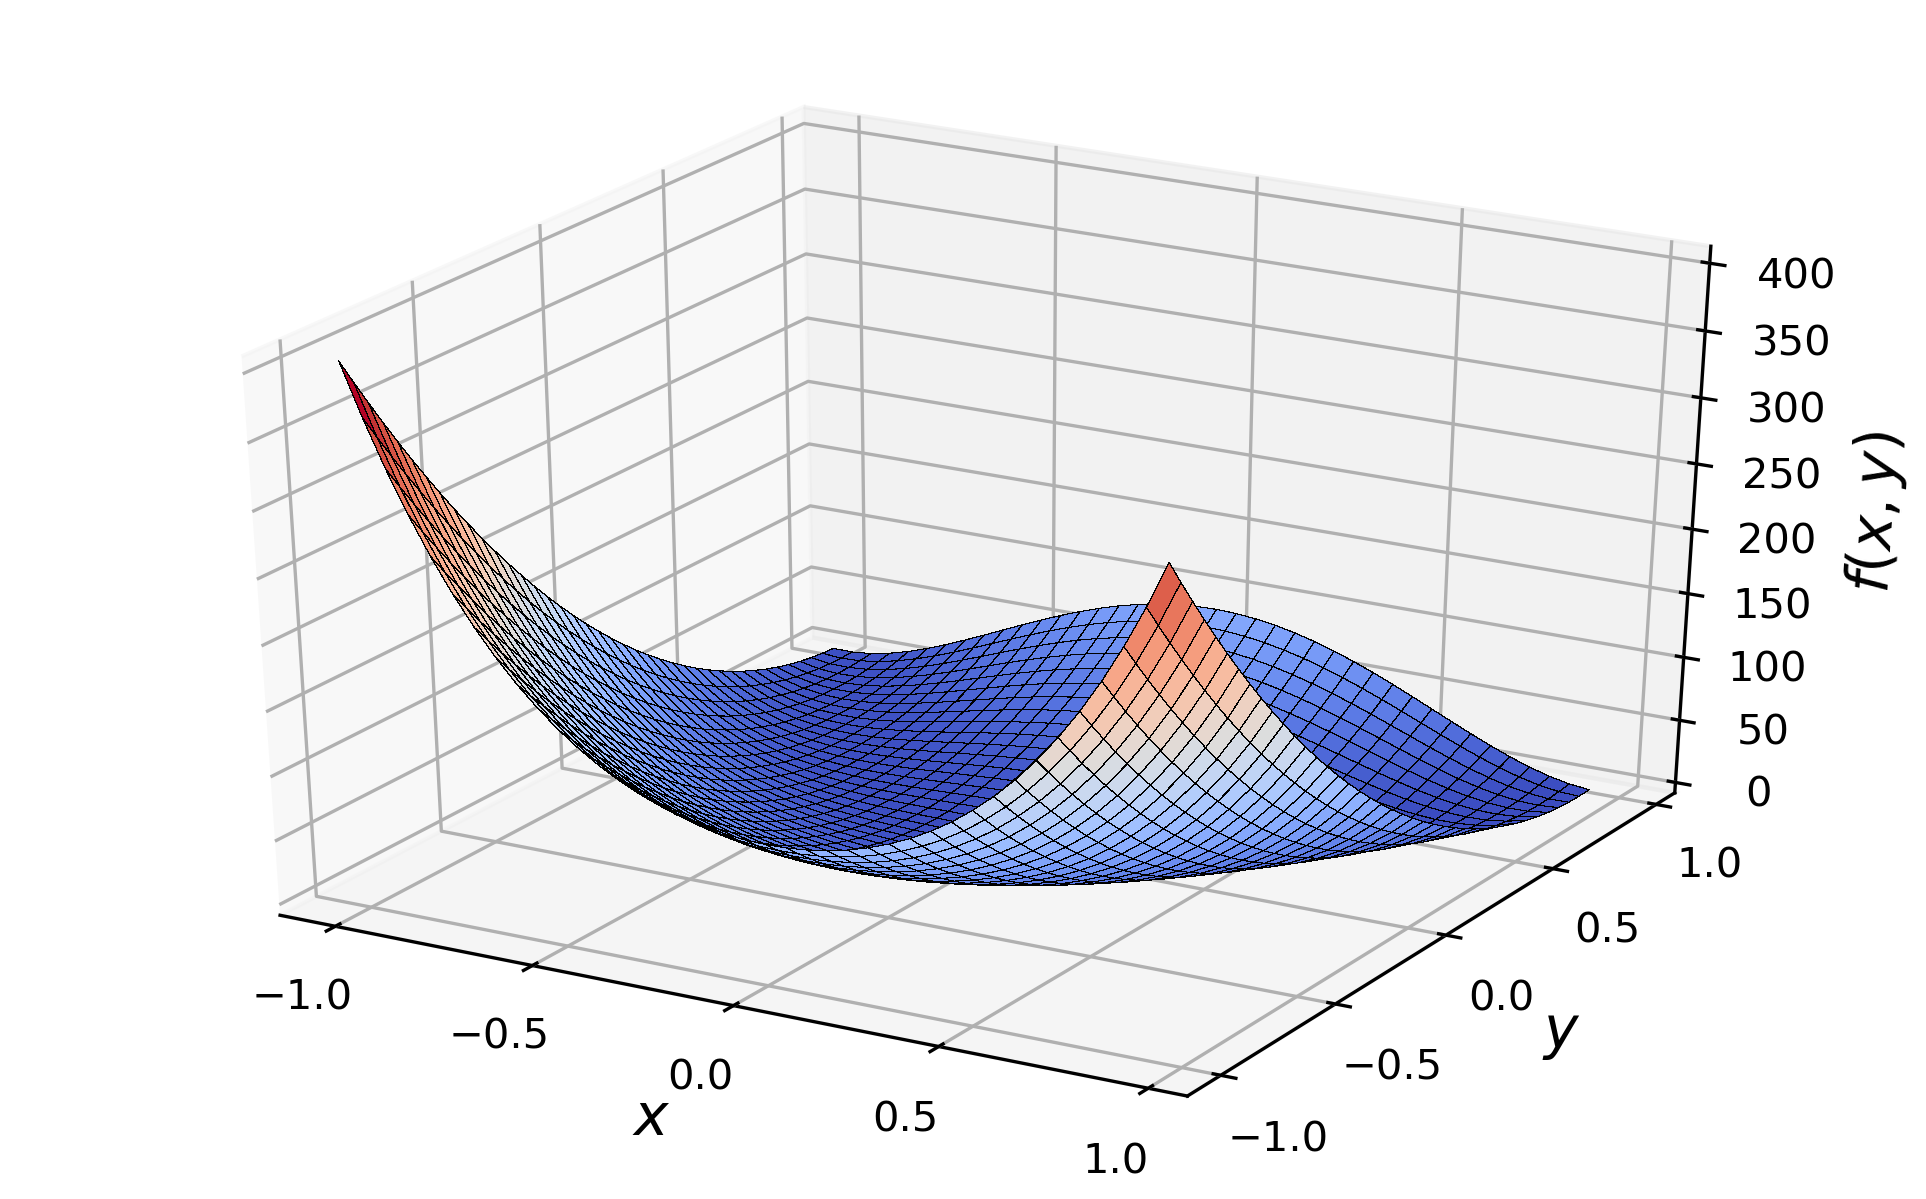

In [16]:
# visualization of approximated function 
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.gca(projection='3d')

# make data
X = np.arange(l_bound, u_bound, 0.05)
Y = np.arange(l_bound, u_bound, 0.05)
X, Y = np.meshgrid(X, Y)

#Z = 2*np.exp(-7*((X**2)/2. + (Y**2)/2.)) 
#Z = np.sin((X**2)/2. - (Y**2)/4. + 3) * np.cos(2*X + 1 - np.exp(Y))
Z = (1-X)**2 + 100*(Y-X**2)**2

# plot the surface
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.01, antialiased=False, edgecolor='black')

# customize the z axis
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_ticks(np.linspace(-1.0,1.0,5))
ax.yaxis.set_ticks(np.linspace(-1.0,1.0,5))

ax.zaxis.set_ticks(np.linspace(0,400,9))
ax.xaxis.set_label_text(r'$x$',fontsize=14)
ax.yaxis.set_label_text(r'$y$',fontsize=14)
ax.zaxis.set_label_text(r'$f(x,y)$',fontsize=14)

# add a color bar which maps values to colors
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig("/Users/vitaly/Desktop/oversampling/results/rosen.pdf",\
        dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# Speed of d/dx

In [ ]:
num = 1000
xx = l_bound + (u_bound - l_bound)*np.random.rand(num, num_points*dim)
# g = grad(log_det.loss_func)
grad_f = grad(log_det.loss_func)
# grad_f = jit(g)

In [ ]:
%%time
for e in xx:
    grad_f(e)

In [ ]:
%%time
for e in xx:
    log_det.grad(e, False)

In [ ]:
list(itertools.product([2,3,4], [7,8,9]))

In [ ]:
a = np.arange(12).reshape(-1, 4)
print (a)

In [ ]:
os.path.isfile("sandbox_GD_approx_settings.py")